# Download

Downloading products is after searching one of the most important features of `eodag`. This page describes the different methods available to download products and the parameters that these methods accept.

You will learn how to:
- [Setup](#Setup)
- [Progress bar](#Progress-bar)
- [Already downloaded product](#Already-downloaded-product)
- [Download quicklooks](#Download-quicklooks)
- [Download EO products](#Download-eo-products)
- [Download assets](#Download-assets)


<div class="alert alert-info">

You should be registered to *PEPS* to run this notebook that downloads data.

</div>

<div class="alert alert-warning">

Warning

The notebook downloads a few EO products. These products are usually in the order of 700-900 Mo, 
make sure you have a decent internet connection if you plan to run the notebooks.

Downloading products from a provider whose storage is based on AWS may incur some cost.

</div>

## Setup

Results obtained from *PEPS* after a search of *Sentinel 2 Level-1C* products over France in March 2021 will be loaded in a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult). But first, the credentials need to be set in order to be able to download anything.

In [1]:
import os
# os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
# os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

A workspace directory is created to store the downloaded products.

In [2]:
workspace = 'eodag_workspace_download'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

By default `eodag` saves products in the directory set by `output_dir` which is by default the system temporary folder (`/tmp` on Linux) and quicklooks in a `quicklooks` subfolder of `output_dir` (`tmp/quicklooks` on Linux). To make them easier to use, `eodag` even stores them in a standardized output tree, regardless of whether the products are stored in a file, folder or archive to be extracted (see below). The path of this tree is defined as `{output_dir}/{title}`, with `title` the title of the products. Here `eodag` is configured to download products in this workspace directory.

In [3]:
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUT_DIR"] = os.path.abspath(workspace)

The `extract` setting could be also defined here. It indicates whether products need to be automatically extracted from their archive or not. They are extracted by default, this setting is not going to be altered here.

We now search and combine results from `peps` and `wekeo_main` to mix *online* and *offline* products.

In [4]:
from eodag import EODataAccessGateway
dag = EODataAccessGateway()

In [5]:
search_results = dag.search(
    provider="peps",
    collection="S2_MSI_L1C",
    start="2021-01-01",
    end="2021-02-01",
    geom={"lonmin": 1, "latmin": 45, "lonmax": 1.5, "latmax": 45.5},
    items_per_page=5
) + dag.search(
    provider="wekeo_main",
    collection="S2_MSI_L1C",
    start="2022-01-01",
    end="2022-02-01",
    geom={"lonmin": 1, "latmin": 45, "lonmax": 1.5, "latmax": 45.5},
    items_per_page=5
)
search_results

SearchResult([EOProduct(id=S2B_MSIL1C_20210130T105209_N0500_R051_T31TCL_20230527T010411, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210130T105209_N0500_R051_T31TCK_20230527T010411, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210125T105331_N0500_R051_T31TCK_20230528T204208, provider=peps),
              EOProduct(id=S2A_MSIL1C_20220130T105301_N0510_R051_T31TCK_20240508T171457, provider=wekeo_main),
              EOProduct(id=S2A_MSIL1C_20220130T105301_N0510_R051_T31TCL_20240508T171457, provider=wekeo_main),
              EOProduct(id=S2B_MSIL1C_20220128T110219_N0510_R094_T31TCL_20240507T103407, provider=wekeo_main),
              EOProduct(id=S2B_MSIL1C_20220125T105229_N0510_R051_T31TCL_20240505T161247, provider=wekeo_main),
              EOProduct(id=S2B_MSIL1C_20220125T105229_N0510_R051_T31TCK_20240505T161247, provider=wekeo_main)])

`delete_archive` is another setting that allows to remove the archive containing products after its extraction, or not. The deletion is activated by default.

Logging is set to see more about what `eodag` does when it downloads products.

In [6]:
from eodag import setup_logging
setup_logging(2)

## Progress bar

`eodag` displays a progress bar every time it downloads products or quicklooks. It uses `tqdm.auto` to create a
 progress bar adapted to the context (Notebook, terminal).
 
### Cutomize progress bar

Progress bars can be customized, using the `progress_callback` parameter of the download methods. Create your own instance of [ProgressCallback](../../api_reference/utils.rst#eodag.utils.ProgressCallback) class, customize it to pass it later to [download](./7_download.ipynb#Download-EO-products) methods:

In [7]:
from eodag.utils import ProgressCallback

with ProgressCallback(total=3, unit="carrots", unit_scale=False, desc="Eating carrots") as progress_callback:
    progress_callback(1)
    progress_callback(2)

Eating carrots:   0%|          | 0/3 [00:00<?, ?carrots/s]

Keep another progress bar opened, and customize it changing `ProgressCallback` [attributes inherited from tqdm](https://github.com/tqdm/tqdm/#documentation):

In [8]:
another_bar = ProgressCallback(dynamic_ncols=False, ncols=300)
another_bar.colour = "purple"

0.00B [00:00, ?B/s]

In [9]:
another_bar(1)

### Mute progress bar

Progress bars can be muted using `setup_logging` and `0` as verbosity level, or `no_progress_bar` parameter.

In [10]:
with ProgressCallback(total=2) as progress_callback:
    progress_callback.desc = "This will be displayed"
    progress_callback.position = 0
    progress_callback(1)

setup_logging(verbose=0)

with ProgressCallback() as progress_callback:
    progress_callback.desc = "This will be hidden"
    progress_callback.position = 1
    progress_callback(1)

setup_logging(verbose=2, no_progress_bar=True)

with ProgressCallback() as progress_callback:
    progress_callback.desc = "This will be hidden"
    progress_callback.position = 2
    progress_callback(1)

setup_logging(verbose=2)

with ProgressCallback() as progress_callback:
    progress_callback.desc = "This will be also displayed"
    progress_callback.position = 3
    progress_callback(1)

with ProgressCallback(disable=True) as progress_callback:
    progress_callback.desc = "This will be hidden"
    progress_callback.position = 4
    progress_callback(1)

  0%|          | 0.00/2.00 [00:00<?, ?B/s]

0.00B [00:00, ?B/s]

## Already downloaded product

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has a `location` attribute that stores either its remote location (before being downloaded) or its local location (after being downloaded). The download methods of `eodag` checks first wheter the product/quicklook to download has been already downloaded. If so, it just returns its path and does not try to download it again.

## Download quicklooks

EO products usually offer a *quicklook* image, a low resolution by-product of the original data. An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has a [get_quicklook()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.get_quicklook) method that takes care of downloading the quicklook image and returns its path. It accepts a `output_dir` (optional) parameter to specify an output directory and a `filename` (optional) parameter to specify an output filename. By default, `eodag` saves a quicklook with its ID as filename.

[get_quicklook()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.get_quicklook) returns the local absolute path to the image downloaded. This is useful to precess it afterwards. Here `matplotlib` is used here to display 4 quicklooks.

0.00B [00:00, ?B/s]

2025-11-04 18:14:38,560 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2B_MSIL1C_20210130T105209_N0500_R051_T31TCL_20230527T010411


0.00B [00:00, ?B/s]

2025-11-04 18:14:38,816 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2B_MSIL1C_20210130T105209_N0500_R051_T31TCK_20230527T010411


0.00B [00:00, ?B/s]

2025-11-04 18:14:39,020 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518


0.00B [00:00, ?B/s]

2025-11-04 18:14:39,332 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208


0.00B [00:00, ?B/s]

2025-11-04 18:14:39,638 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2A_MSIL1C_20210125T105331_N0500_R051_T31TCK_20230528T204208


0.00B [00:00, ?B/s]

2025-11-04 18:14:40,153 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2A_MSIL1C_20220130T105301_N0510_R051_T31TCK_20240508T171457


0.00B [00:00, ?B/s]

2025-11-04 18:14:40,677 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2A_MSIL1C_20220130T105301_N0510_R051_T31TCL_20240508T171457


0.00B [00:00, ?B/s]

2025-11-04 18:14:41,173 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2B_MSIL1C_20220128T110219_N0510_R094_T31TCL_20240507T103407


0.00B [00:00, ?B/s]

2025-11-04 18:14:41,681 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2B_MSIL1C_20220125T105229_N0510_R051_T31TCL_20240505T161247


0.00B [00:00, ?B/s]

2025-11-04 18:14:42,318 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/quicklooks/S2B_MSIL1C_20220125T105229_N0510_R051_T31TCK_20240505T161247


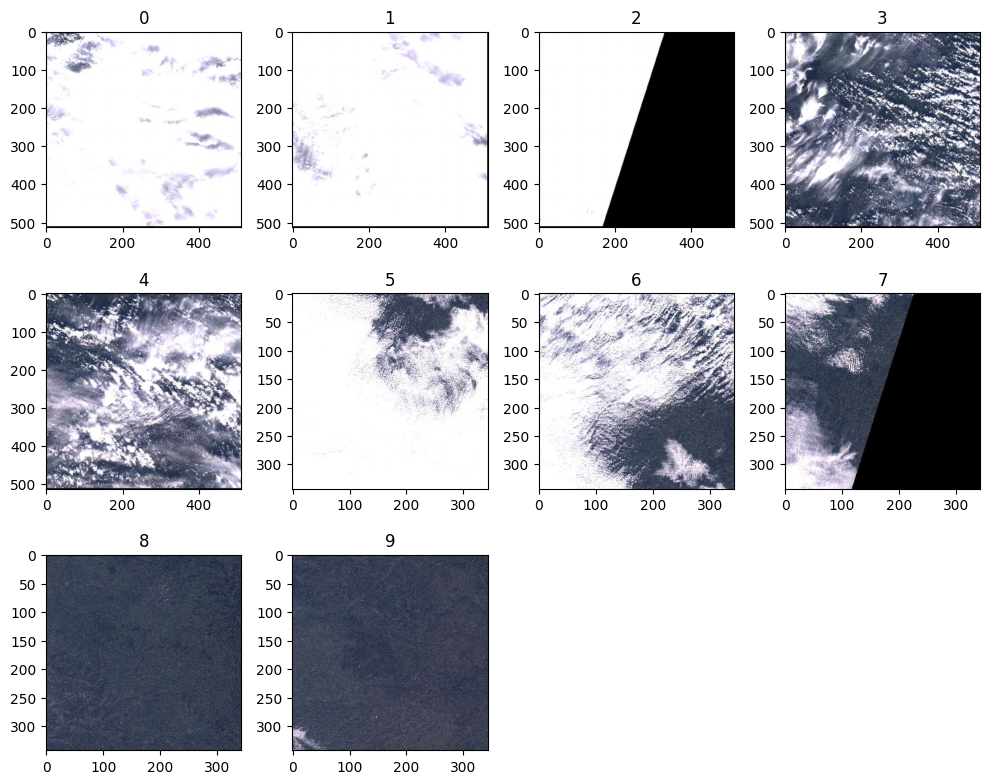

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(search_results, start=1):
    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()

    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()

## Download EO products

### Dynamically configure some download options

The 3 download methods introduced below accept the following optional kwargs that temporarily override the global configuration:

* `output_dir` (`str`): absolute path to a folder where the products should be saved
* `extract` (`bool`): whether to automatically extract or not the downloaded product archive
* `dl_url_params` (`dict`): additional parameters to pass over to the download url as an url parameter
* `delete_archive` (`bool`): whether to delete the downloaded archives

### Order orderable products

As introduced in the [getting started guide](../../getting_started_guide/product_storage_status.rst) an EO product may not be available for download immediately. If the product status is `orderable`, the download methods will request an order of the product and, by default, retry to download it every 2 minutes during 20 minutes. These two durations can be set with the `wait` (in minutes) and `timeout` (in minutes) optional parameters of all the download methods.

The storage status of a product can be obtained from its `order:status` field. The status of an `orderable` product is updated by `eodag` to `ordered` when ordered and to `succeeded` when found available.

In [12]:
[p.properties["order:status"] for p in search_results]

['succeeded',
 'succeeded',
 'succeeded',
 'succeeded',
 'succeeded',
 'orderable',
 'orderable',
 'orderable',
 'orderable',
 'orderable']

A `FilterProperty` can be used to filter out `orderable` products to avoid triggering any product order ([SearchResult.filter_online()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.filter_online) method could also have been used).

In [13]:
online_search_results = search_results.filter_property(
    **{"order:status": "succeeded"}
)
[p.properties["order:status"] for p in online_search_results]

2025-11-04 18:14:50,609 eodag.crunch.property            [INFO    ] Finished filtering products. 5 resulting products


['succeeded', 'succeeded', 'succeeded', 'succeeded', 'succeeded']

### Download multiple products at once

[EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) offers a [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) method that takes a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) argument and will try to download each [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) it contains. They are downloaded in parallel by an executor which is an instance of `ThreadPoolExecutor` class. `executor` parameter of [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) method can be used to customize the executor (e.g. to define its maximum number of workers), otherwise a default `ThreadPoolExecutor` instance will be set. It returns a list of absolute paths to the downloaded products. For the purpose of this user guide only 2 products will be downloaded and with a customized executor using 2 workers at most.

In [14]:
from concurrent.futures import ThreadPoolExecutor

products_to_download = online_search_results[2:4]
paths = dag.download_all(products_to_download, executor=ThreadPoolExecutor(max_workers=2))

2025-11-04 18:18:08,975 eodag.core                       [INFO    ] Downloading 2 products


Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

2025-11-04 18:18:09,011 eodag.download.base              [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/4958e516-cdc2-5034-9348-89dc66fef851/download


0.00B [00:00, ?B/s]

2025-11-04 18:18:09,013 eodag.download.base              [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/fc32ce41-1bec-5af6-a1e5-cab04878467c/download
2025-11-04 18:18:34,755 eodag.download.base              [INFO    ] Extraction activated
2025-11-04 18:18:35,778 eodag.download.base              [INFO    ] Deleting archive S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518.zip
2025-11-04 18:18:35,846 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/fc32ce41-1bec-5af6-a1e5-cab04878467c/download
2025-11-04 18:18:42,266 eodag.download.base              [INFO    ] Extraction activated
2025-11-04 18:18:44,419 eodag.download.base              [INFO    ] Deleting archive S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208.zip
2025-11-04 18:18:44,584 eodag.product                    [INFO    ] Remote location of the product is 

In [15]:
paths

['/home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518',
 '/home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208']

The products have been downloaded as archived files (*Sentinel* products are distributed in the [SAFE format](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats)). The logs above and the command below show that `eodag` then took care of extracting them to their own directory and deleting them afterward.

In [16]:
!ls {workspace}

quicklooks
S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208
S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518


In [17]:
!tree -sh {paths[0]}

[4.0K]  /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518
├── [4.0K]  AUX_DATA
├── [4.0K]  DATASTRIP
│   └── [4.0K]  DS_S2RP_20230527T222518_S20210128T110447
│       ├── [ 23M]  MTD_DS.xml
│       └── [4.0K]  QI_DATA
│           ├── [ 24K]  FORMAT_CORRECTNESS.xml
│           ├── [8.0K]  GENERAL_QUALITY.xml
│           ├── [9.1K]  GEOMETRIC_QUALITY.xml
│           ├── [7.3K]  RADIOMETRIC_QUALITY.xml
│           └── [4.8K]  SENSOR_QUALITY.xml
├── [4.0K]  GRANULE
│   └── [4.0K]  L1C_T31TCL_A029263_20210128T110447
│       ├── [4.0K]  AUX_DATA
│       │   ├── [2.9K]  AUX_CAMSRE
│       │   └── [1.6K]  AUX_ECMWFT
│       ├── [4.0K]  IMG_DATA
│       │   ├── [1.8M]  T31TCL_20210128T110321_B01.jp2
│       │   ├── [ 49M]  T31TCL_20210128T110321_B02.jp2
│       │   ├── [ 48M]  T31TCL_20210128T110321_B03.jp2
│       │   ├── [ 49M]  T31TCL_20210128T110321_B04.jp2
│       │   ├── [ 13M]  T31TCL_20210128T110321_B05.jp2
│  

`eodag` saves a file in the `output_dir` folder that contains a hash list of the products downloaded. Before downloading products, this file is read and it is checked whether the products to download were already downloaded or not. If they were, their download is skipped.

In [18]:
products_to_download = online_search_results[2:4]
dag.download_all(products_to_download)

2025-11-04 18:19:10,622 eodag.core                       [INFO    ] Downloading 2 products


Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

2025-11-04 18:19:10,656 eodag.download.base              [INFO    ] Product already present on this platform. Identifier: /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518
2025-11-04 18:19:10,657 eodag.download.base              [INFO    ] Product already present on this platform. Identifier: /home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208
2025-11-04 18:19:10,658 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/fc32ce41-1bec-5af6-a1e5-cab04878467c/download
2025-11-04 18:19:10,660 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/4958e516-cdc2-5034-9348-89dc66fef851/download


['/home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210128T110321_N0500_R094_T31TCL_20230527T222518',
 '/home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20210125T105331_N0500_R051_T31TCL_20230528T204208']

### Download a single product

[EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) also offers a [download()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download) method that takes an [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) argument and will try to download it. It is a wrapper around the [download()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.download) method that each [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has. Its advantage over the latter is that, similarly to what does [deserialize_and_register()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.deserialize_and_register), it adds the information required for a product to download itself if it was missing. It does so by extracting the product's provider and getting the right authentication and download plugins. Both methods return the absolute path to the downloaded product.

### Download an orderable product

This examples shows what logs `eodag` emits when it tries to download a product that is originally `orderable`. It is set to retry downloading the product every 1 minute after ordering it, and to stop trying (skip it if [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) is used) after 5 minutes.

In [19]:
offline_product = search_results.filter_property(
    **{"order:status": "orderable"}
)[1]
offline_product.properties["order:status"]

2025-11-04 18:19:41,290 eodag.crunch.property            [INFO    ] Finished filtering products. 5 resulting products


'orderable'

In [20]:
setup_logging(verbose=2)
path = dag.download(
    offline_product,
    wait=1,
    timeout=10,
)

0.00B [00:00, ?B/s]

2025-11-04 18:19:44,947 eodag.download.base              [INFO    ] Download url: https://catalogue.dataspace.copernicus.eu/download/312e2c98-7eb4-499f-978c-d0924785adc7


2025-11-04 18:19:45,881 eodag.download.base              [INFO    ] S2A_MSIL1C_20220130T105301_N0510_R051_T31TCL_20240508T171457.SAFE(initially ORDERED) requested, returned: 


2025-11-04 18:21:24,372 eodag.download.base              [INFO    ] Extraction activated
2025-11-04 18:21:26,240 eodag.download.base              [INFO    ] Deleting archive S2A_MSIL1C_20220130T105301_N0510_R051_T31TCL_20240508T171457.zip
2025-11-04 18:21:26,406 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://gateway.prod.wekeo2.eu/hda-broker/api/v1/dataaccess/download/690a35b11c4a9ac60e3b12b2


In [21]:
path

'/home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20220130T105301_N0510_R051_T31TCL_20240508T171457'

Now the `location` attribute rightfully points to its local path.

In [22]:
offline_product.location

'file:///home/anesson/workspace/EODAG/eodag-debug/eodag_workspace_download/S2A_MSIL1C_20220130T105301_N0510_R051_T31TCL_20240508T171457'

## Download assets

Searching on some providers (mainly STAC providers) returns products having an `assets` attribute listing single files that can be individually downloaded.

In [23]:
search_results = dag.search(
    collection="S2_MSI_L2A", 
    provider="planetary_computer"
)

2025-11-04 18:21:55,967 eodag.core                       [INFO    ] Searching on provider planetary_computer
2025-11-04 18:21:55,968 eodag.search.qssearch            [INFO    ] Fetching queryables: https://planetarycomputer.microsoft.com/api/stac/v1/search/../collections/sentinel-2-l2a/queryables
2025-11-04 18:21:56,251 eodag.search.qssearch            [INFO    ] Sending search request: https://planetarycomputer.microsoft.com/api/stac/v1/search


In [24]:
# view assets
search_results[0].assets

{'AOT_10m': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R10m/T33WVS_20251104T112139_AOT_10m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [10980, 10980], 'proj:transform': [10.0, 0.0, 399960.0, 0.0, -10.0, 7700040.0], 'gsd': 10.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'AOT_10m'}, 'B01': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R60m/T33WVS_20251104T112139_B01_60m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [1830, 1830], 'proj:transform': [60.0, 0.0, 399960.0, 0.0, -60.0, 7700040.0], 'gsd': 60.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'B01', 'eo:bands': [{'name': 'B01', 'common_name': 'coastal', 'description': 'Band 1 - Coastal aerosol', 'center_wavelength': 0.443, 'full_width_half_max': 0.027}]}, 'B02': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R10m/T33WVS_20251104T112139_B02_10m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [10980, 10980], 'proj:transform': [10.0, 0.0, 399960.0, 0.0, -10.0, 7700040.0], 'gsd': 10.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'B02', 'eo:bands': [{'name': 'B02', 'common_name': 'blue', 'description': 'Band 2 - Blue', 'center_wavelength': 0.49, 'full_width_half_max': 0.098}]}, 'B03': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R10m/T33WVS_20251104T112139_B03_10m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [10980, 10980], 'proj:transform': [10.0, 0.0, 399960.0, 0.0, -10.0, 7700040.0], 'gsd': 10.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'B03', 'eo:bands': [{'name': 'B03', 'common_name': 'green', 'description': 'Band 3 - Green', 'center_wavelength': 0.56, 'full_width_half_max': 0.045}]}, 'B04': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R10m/T33WVS_20251104T112139_B04_10m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [10980, 10980], 'proj:transform': [10.0, 0.0, 399960.0, 0.0, -10.0, 7700040.0], 'gsd': 10.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'B04', 'eo:bands': [{'name': 'B04', 'common_name': 'red', 'description': 'Band 4 - Red', 'center_wavelength': 0.665, 'full_width_half_max': 0.038}]}, 'B05': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R20m/T33WVS_20251104T112139_B05_20m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [5490, 5490], 'proj:transform': [20.0, 0.0, 399960.0, 0.0, -20.0, 7700040.0], 'gsd': 20.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'B05', 'eo:bands': [{'name': 'B05', 'common_name': 'rededge', 'description': 'Band 5 - Vegetation red edge 1', 'center_wavelength': 0.704, 'full_width_half_max': 0.019}]}, 'B06': {'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_202511

In [25]:
# view single asset content
search_results[0].assets["B05"]

{'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/33/W/VS/2025/11/04/S2B_MSIL2A_20251104T112139_N0511_R037_T33WVS_20251104T120606.SAFE/GRANULE/L2A_T33WVS_A045251_20251104T112139/IMG_DATA/R20m/T33WVS_20251104T112139_B05_20m.tif', 'proj:bbox': [399960.0, 7590240.0, 509760.0, 7700040.0], 'proj:shape': [5490, 5490], 'proj:transform': [20.0, 0.0, 399960.0, 0.0, -20.0, 7700040.0], 'gsd': 20.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'B05', 'eo:bands': [{'name': 'B05', 'common_name': 'rededge', 'description': 'Band 5 - Vegetation red edge 1', 'center_wavelength': 0.704, 'full_width_half_max': 0.019}]}

Configure provider for download, if not already done

In [8]:
dag.update_providers_config(f"""
    planetary_computer:
        auth:
            credentials:
                apikey: PLEASE_CHANGE_ME
        download:
            output_dir: {os.path.abspath(workspace)}
""")


Download several assets using core `download()` method, allowing regex in `asset` parameter to identify assets to download

In [26]:
path = dag.download(search_results[0], asset=r"B0[23]")
path

0.00B [00:00, ?B/s]

2025-11-04 18:22:11,678 eodag.download.base              [INFO    ] Download url: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606
2025-11-04 18:22:13,688 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606


'/tmp/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606'

In [27]:
! tree -sh {path}

[4.0K]  /tmp/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606
├── [9.3M]  T33WVS_20251104T112139_B02_10m.tif
└── [9.3M]  T33WVS_20251104T112139_B03_10m.tif

1 directory, 2 files


Download a single asset using `asset.download()` method

In [28]:
path = search_results[0].assets["B05"].download()
path

0.00B [00:00, ?B/s]

2025-11-04 18:22:19,702 eodag.download.base              [INFO    ] Download url: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606


2025-11-04 18:22:20,490 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606


'/tmp/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606'

In [29]:
! tree -sh {path}

[4.0K]  /tmp/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606
├── [9.3M]  T33WVS_20251104T112139_B02_10m.tif
├── [9.3M]  T33WVS_20251104T112139_B03_10m.tif
└── [2.9M]  T33WVS_20251104T112139_B05_20m.tif

1 directory, 3 files


If `asset` parameter is not defined or matches more than one asset, assets are downloaded in parallel. The executor which allows this is set the same way as explained in [the download multiple products at once section](#Download-multiple-products-at-once). Let's download the remaining assets of the first product in parallel and with a customized executor using 4 workers at most.

In [30]:
path = dag.download(search_results[0], executor=ThreadPoolExecutor(max_workers=4))
path

0.00B [00:00, ?B/s]

2025-11-04 18:22:49,212 eodag.download.base              [INFO    ] Download url: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606
2025-11-04 18:23:03,082 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606


'/tmp/S2B_MSIL2A_20251104T112139_R037_T33WVS_20251104T120606'

<div class="alert alert-info">

The executor used to download several products in parallel with the [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) method may be reused to download assets of these products if they have any.

</div>